Example from https://www.tensorflow.org/tutorials/generative/dcgan#the_generator

# Imports

In [8]:
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
# check that gpu is available:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load MNIST Dataset

In [30]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [31]:
print(x_train.min(), x_train.max(), x_train.dtype, x_train.shape)
print(y_train.min(), y_train.max(), y_train.dtype, y_train.shape)

0 255 uint8 (60000, 28, 28)
0 9 uint8 (60000,)


In [32]:
x_train = x_train / 255.
x_test = x_test / 255.
x_train.shape += (1,)
x_test.shape += (1,)

In [33]:
print(x_train.min(), x_train.max(), x_train.dtype, x_train.shape)
print(y_train.min(), y_train.max(), y_train.dtype, y_train.shape)

0.0 1.0 float64 (60000, 28, 28, 1)
0 9 uint8 (60000,)


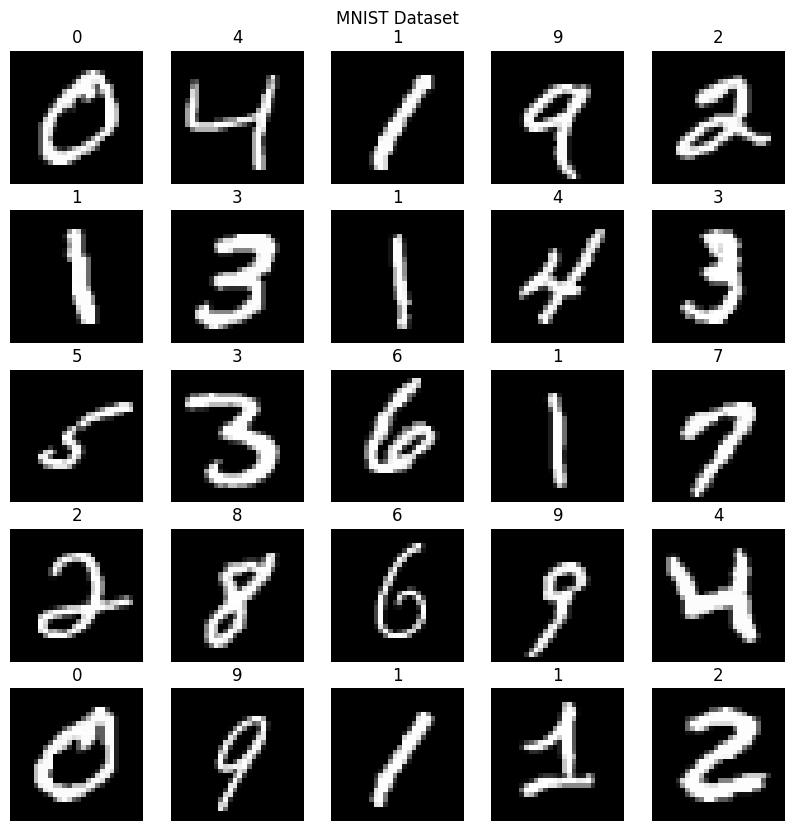

In [17]:
# Visualize some numbers

plt.figure(figsize=(10, 10))
plt.title("MNIST Dataset", pad=20)
plt.axis(False)

for i in range(0, 5):
    for j in range(0, 5):

        idx = i * 5 + j + 1
        plt.subplot(5, 5, idx)
        plt.imshow(x_train[idx], cmap="gray")
        plt.title(y_train[idx])
        plt.axis(False)

# Some basic GAN

## Discriminator

In [444]:
disc = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(64, 5, strides=2, padding="same", activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, 5, strides=2, padding="same", activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

## Generator

In [445]:
gen = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128,)),
    tf.keras.layers.Dense(7*7*256, use_bias=False),
    tf.keras.layers.Reshape((7, 7, 256)),
    tf.keras.layers.Conv2DTranspose(128, 5, strides=1, padding="same", activation="relu", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, 5, strides=2, padding="same", activation="relu", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, 5, strides=2, padding="same", activation="sigmoid", use_bias=False),
])

gen.output_shape

(None, 28, 28, 1)

0.47553366 0.5193699 float32 (16, 28, 28, 1)


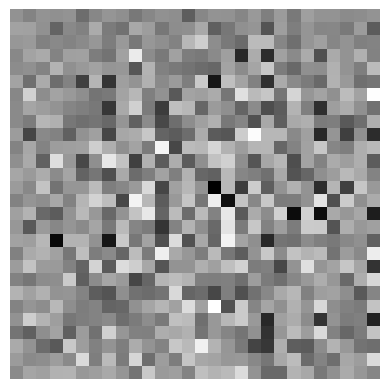

In [446]:
rand = tf.random.normal((16, 128, 1))
out = gen(rand, training=False)

plt.imshow(out[0], cmap="gray")
plt.axis(False)

out = out.numpy()
print(out.min(), out.max(), out.dtype, out.shape)
del out, rand

## Combined model

In [447]:
bc = tf.keras.losses.BinaryCrossentropy()
def discriminator_loss(real, fake):
    real_loss = bc(tf.ones_like(real), real)
    fake_loss = bc(tf.zeros_like(fake), fake)
    return real_loss + fake_loss

def generator_loss(fake):
    return bc(tf.ones_like(fake), fake)

In [448]:
class GAN(tf.keras.Model):
    def __init__(self, gen, disc):
        super().__init__()

        self.gen = gen
        self.disc = disc

    def compile(self, g_optimizer, d_optimizer, gen_loss, disc_loss):
        super().compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss

    def train_step(self, real_images):
        shape = tf.shape(real_images)
        rand = tf.random.normal((shape[0], 128, 1))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            fake_images = self.gen(rand, training=True)

            out = self.disc(real_images, training=True)
            fake_out = self.disc(fake_images, training=True)

            g_loss = self.gen_loss(fake_out)
            d_loss = self.disc_loss(out, fake_out) * 0.7

        gen_grads = gen_tape.gradient(g_loss, self.gen.trainable_weights)
        disc_grads = disc_tape.gradient(d_loss, self.disc.trainable_weights)
        self.d_optimizer.apply_gradients(zip(disc_grads, self.disc.trainable_weights))
        self.g_optimizer.apply_gradients(zip(gen_grads, self.gen.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

In [449]:
gan = GAN(gen, disc)

gan.compile(
    tf.keras.optimizers.Adam(1e-4),
    tf.keras.optimizers.Adam(1e-4),
    generator_loss,
    discriminator_loss
)

In [450]:
history = gan.fit(x_train, batch_size=32, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 40s 20ms/step - d_loss: 0.5167 - g_loss: 2.0035
Epoch 2/10
1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.7285 - g_loss: 1.0868
Epoch 3/10
1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.8054 - g_loss: 0.9795
Epoch 4/10
1875/1875 [==============================] - 40s 22ms/step - d_loss: 0.8153 - g_loss: 0.9485
Epoch 5/10
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.7704 - g_loss: 1.0222
Epoch 6/10
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.7152 - g_loss: 1.1297
Epoch 7/10
1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6784 - g_loss: 1.2153
Epoch 8/10
1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6345 - g_loss: 1.3245
Epoch 9/10
1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.5945 - g_loss: 1.4336
Epoch 10/10
1875/1875 [==============================] - 41s 22m

## Visualize training process

Text(0, 0.5, 'Loss')

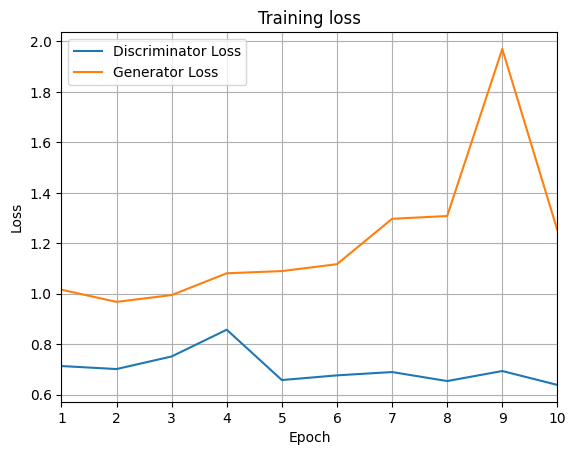

In [455]:
plt.title("Training loss")
plt.plot(list(range(1, 11)), history.history["d_loss"])
plt.plot(list(range(1, 11)), history.history["g_loss"])
plt.xlim(1, 10)
plt.grid()
plt.legend(["Discriminator Loss", "Generator Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Visualize results

In [456]:
rand = tf.random.uniform((25, 128, 1))
out = gen(rand, training=False)
out.shape

TensorShape([25, 28, 28, 1])

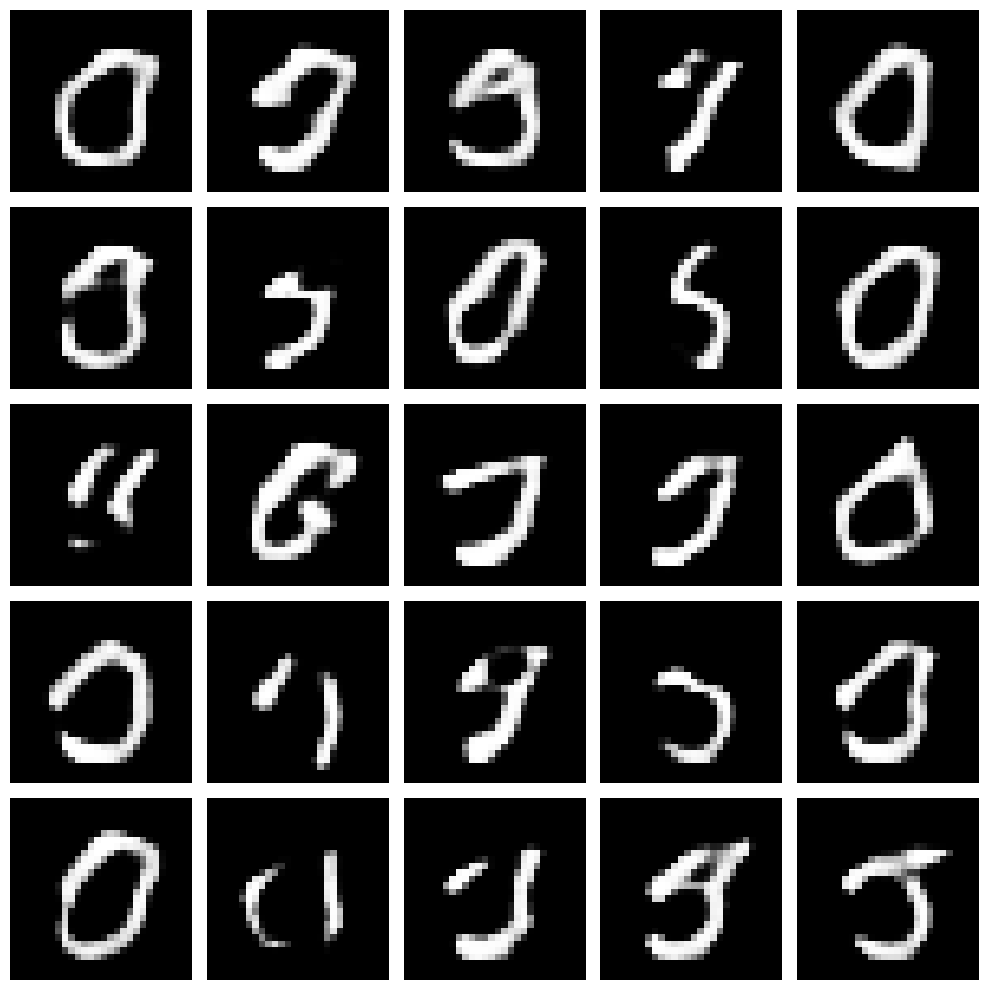

In [457]:
plt.figure(figsize=(10, 10))

for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        plt.subplot(5, 5, idx + 1)
        plt.axis(False)
        plt.imshow(out[idx], cmap="gray")

plt.tight_layout()